## Data Science Tutorial

* Titanic data from OpenML.org as a csv file named data.csv [OpenML](https://www.openml.org/d/40945)
* Import the [pandas](https://pandas.pydata.org/) and [numpy](https://numpy.org/) libraries, two common libraries used for manipulating data, and loading the Titanic data into a pandas [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('data.csv')

* Before the data can be graphed though, you need to make sure that there aren't any issues with it. If you look at the Titanic csv file, one thing you'll notice is that a question mark ("?") was used to designate cells where data wasn't available.

* While Pandas can read this value into a DataFrame, the result for a column like Age is that its data type will be set to Object instead of a numeric data type, which is problematic for graphing.

* Replace the question marks in the age and fare columns with the numpy NaN value. Notice that we also need to update the column's data type after replacing the values.

In [2]:
data.replace('?', np.nan, inplace= True)
data = data.astype({"age": np.float64, "fare": np.float64})

* Now that the data is in good shape, you can use [seaborn](https://seaborn.pydata.org/) and [matplotlib](https://matplotlib.org/) to view how certain columns of the dataset relate to survivability.

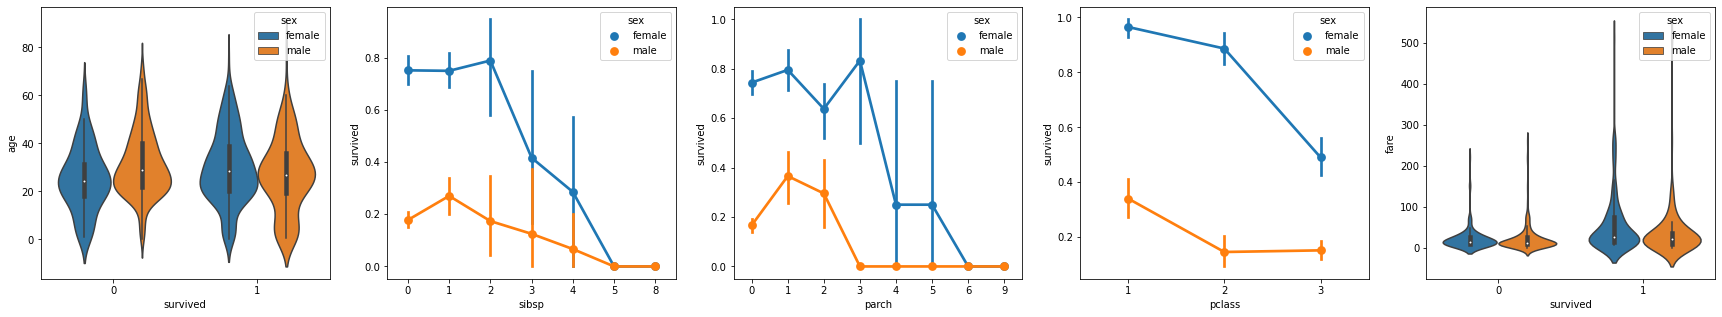

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=5, figsize=(30,5))
sns.violinplot(x="survived", y="age", hue="sex", data=data, ax=axs[0])
sns.pointplot(x="sibsp", y="survived", hue="sex", data=data, ax=axs[1])
sns.pointplot(x="parch", y="survived", hue="sex", data=data, ax=axs[2])
sns.pointplot(x="pclass", y="survived", hue="sex", data=data, ax=axs[3])
sns.violinplot(x="survived", y="fare", hue="sex", data=data, ax=axs[4])

* These graphs are helpful in seeing some of the relationships between survival and the input variables of the data, but it's also possible to use pandas to calculate correlations. To do so, all the variables used need to be numeric for the correlation calculation and currently gender is stored as a string.

In [4]:
data.replace({'male': 1, 'female': 0}, inplace=True)


* Now, you can analyze the correlation between all the input variables to identify the features that would be the best inputs to a machine learning model. The closer a value is to 1, the higher the correlation between the value and the result. 

In [5]:
data.corr().abs()[["survived"]]


,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055513
sibsp,0.027825
parch,0.082660
fare,0.244265


* Looking at the correlation results, you'll notice that some variables like gender have a fairly high correlation to survival, while others like relatives (sibsp = siblings or spouse, parch = parents or children) seem to have little correlation.

* Let's hypothesize that sibsp and parch are related in how they affect survivability, and group them into a new column called "relatives" to see whether the combination of them has a higher correlation to survivability. To do this, you will check if for a given passenger, the number of sibsp and parch is greater than 0 and, if so, you can then say that they had a relative on board.

In [6]:
data['relatives'] = data.apply (lambda row: int((row['sibsp'] + row['parch']) > 0), axis=1)
data.corr().abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055513
sibsp,0.027825
parch,0.082660
fare,0.244265
relatives,0.201719


* You'll notice that in fact when looked at from the standpoint of whether a person had relatives, versus how many relatives, there is a higher correlation with survival. With this information in hand, you can now drop from the dataset the low value sibsp and parch columns, as well as any rows that had NaN values, to end up with a dataset that can be used for training a model.

* Although age had a low direct correlation, it was kept because it seems reasonable that it might still have correlation in conjunction with other inputs.

In [7]:
data = data[['sex', 'pclass','age','relatives','fare','survived']].dropna()


### Train and evaluate the model

* A common first step to training a model is to divide up the dataset into training and validation data. This allows you to use a portion of the data to train the model and a portion of the data to test the model. If you used all your data to train the model, you wouldn't have a way to estimate how well it would actually perform against data the model has not yet seen. A benefit of the [scikit-learn](https://scikit-learn.org/stable/) library is that it provides a method specifically for splitting a dataset into training and test data.

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data[['sex','pclass','age','relatives','fare']], data.survived, test_size=0.2, random_state=0)

* Next, you'll normalize the inputs such that all features are treated equally. For example, within the dataset the values for age range from ~0-100, while gender is only a 1 or 0. By normalizing all the variables, you can ensure that the ranges of values are all the same.

In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

* There are a number of different machine learning algorithms that you could choose from to model the data and scikit-learn provides support for a number of them, as well as a chart to help select the one that's right for your scenario. For now, use the Naïve Bayes algorithm, a common algorithm for classification problems.

In [10]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

* With a trained model, you can now try it against the test data set that was held back from training. Add and run the following code to predict the outcome of the test data and calculate the accuracy of the model.

In [11]:
from sklearn import metrics
predict_test = model.predict(X_test)
print(metrics.accuracy_score(y_test, predict_test))

0.7464114832535885


### Use a neural network to increase accuracy

* Use the [Keras](https://keras.io/) library with [TensorFlow](https://www.tensorflow.org/) to construct the neural network, and explore how it handles the Titanic dataset.


* The first step is to import the required libraries and to create the model. In this case, you'll use a Sequential neural network, which is a layered neural network wherein there are multiple layers that feed into each other in sequence.

In [13]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

* After defining the model, the next step is to add the layers of the neural network. For now, let's keep things simple and just use three layers.

In [14]:
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 5))
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))

- The first layer will be set to have a dimension of 5, since you have 5 inputs: sex, pclass, age, relatives, and fare.
- The last layer must output 1, since you want a 1-dimensional output indicating whether a passenger would survive.
- The middle layer was kept at 5 for simplicity, although that value could have been different.

The rectified linear unit (relu) activation function is used as a good general activation function for the first two layers, while the sigmoid activation function is required for the final layer as the output you want (of whether a passenger survives or not) needs to be scaled in the range of 0-1 (the probability of a passenger surviving).

Summary of the model:

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


* Once the model is created, it needs to be compiled. As part of this, you need to define what type of optimizer will be used, how loss will be calculated, and what metric should be optimized for.

In [16]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
836/836 [==============================] - 1s 851us/step - loss: 0.6923 - accuracy: 0.5909
Epoch 2/50
836/836 [==============================] - 1s 825us/step - loss: 0.6901 - accuracy: 0.5861
Epoch 3/50
836/836 [==============================] - 1s 839us/step - loss: 0.6863 - accuracy: 0.5921
Epoch 4/50
836/836 [==============================] - 1s 800us/step - loss: 0.6791 - accuracy: 0.7069
Epoch 5/50
836/836 [==============================] - 1s 776us/step - loss: 0.6668 - accuracy: 0.7548
Epoch 6/50
836/836 [==============================] - 1s 788us/step - loss: 0.6502 - accuracy: 0.7656
Epoch 7/50
836/836 [==============================] - 1s 787us/step - loss: 0.6308 - accuracy: 0.7679
Epoch 8/50
836/836 [==============================] - 1s 798us/step - loss: 0.6107 - accuracy: 0.7763
Epoch 9/50
836/836 [==============================] - 1s 823us/step - loss: 0.5924 - accuracy: 0.7763
Epoch 10/50
836/836 [==============================] - 1s 802us/step - loss: 0.576

* With the model built and trained its now time to see how it performs against the test data.



In [17]:
y_pred = model.predict_classes(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7894736842105263


* Similar to the training, you'll notice that you were able to get close to 80% accuracy in predicting survival of passengers. This result was better than the 75% accuracy from the Naive Bayes Classifier tried previously